In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Read in Data

In [196]:
links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
tags = pd.read_csv('./data/ml-latest-small/tags.csv')

In [197]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [198]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [199]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [200]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [201]:
#extract year from movie title
movies['year'] = movies.title.str.extract(r'\((\d{4})\)')
movies.year = np.where(movies.year.isnull() == True,1899,movies.year).astype(int)

In [202]:
#get average rating and total number of ratings for each movie
movies = movies.join(ratings.groupby('movieId').rating.describe()[['count','mean']],on='movieId')

In [203]:
#parse genres and get dummy cols for each genre

movies = movies.join(pd.get_dummies(movies.genres.str.split('|').apply(pd.Series).stack()).sum(level=0))

In [204]:
#rename cols for ease of use
movies.rename(columns={'count':'num_ratings','mean':'avg_rating',
                       '(no genres listed)':'no_genre_listed','Film-Noir':'FilmNoir',
                       'Sci-Fi':'SciFi'},inplace=True)

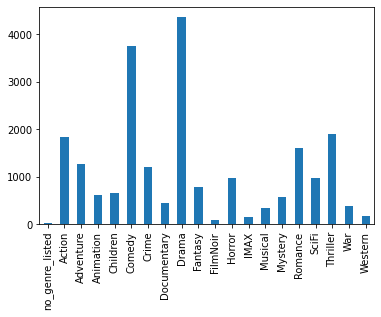

In [205]:
#distribution of grenres, high imbalance, will be much easier to guess drama, comedy, because of size, but also
# may not be specific enough to make quality reccomendations
# but if genre is small and rated highly easy to reccomend other movies in that genre
movies.loc[:,'no_genre_listed':].sum().plot(kind = 'bar')

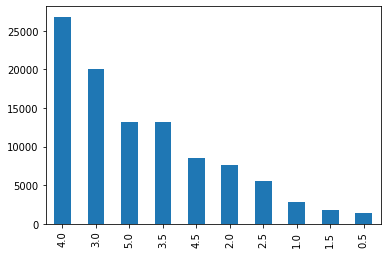

In [206]:
#most people rate >3.0 meaning that people tend to not give negative reviews, <2.5 
#could be a type of move to really avoid
ratings.rating.value_counts().plot(kind='bar')

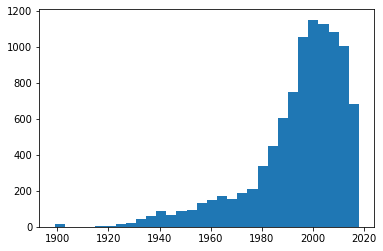

In [207]:
#distribution of movies releases
plt.hist(movies.year,bins = 30);

In [208]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [210]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [220]:
tags.groupby('movieId').tag.value_counts().head(100)

movieId  tag             
1        pixar               2
         fun                 1
2        Robin Williams      1
         fantasy             1
         game                1
                            ..
150      space               1
153      superhero           2
160      Michael Crichton    1
161      submarine           1
162      In Netflix queue    1
Name: tag, Length: 100, dtype: int64

In [224]:
movies.num_ratings.sort_values(ascending=False).head(50)

314     329.0
277     317.0
257     307.0
510     279.0
1939    278.0
224     251.0
418     238.0
97      237.0
507     224.0
461     220.0
2226    218.0
0       215.0
898     211.0
46      204.0
2145    204.0
43      203.0
615     202.0
123     201.0
900     200.0
3638    198.0
911     196.0
659     192.0
398     190.0
509     189.0
1503    188.0
4137    188.0
4800    185.0
506     183.0
520     181.0
2078    179.0
337     178.0
31      177.0
322     172.0
969     171.0
334     171.0
2674    170.0
3194    170.0
1183    165.0
508     164.0
546     162.0
302     161.0
3141    159.0
325     157.0
6710    149.0
4427    149.0
512     146.0
915     146.0
793     145.0
138     144.0
436     144.0
Name: num_ratings, dtype: float64

In [2]:
import surprise

In [11]:
from surprise import Dataset
from surprise.model_selection import train_test_split

In [12]:
surprise_moives = Dataset.load_builtin(name='ml-100k')

In [13]:
train, test = train_test_split(surprise_moives, test_size = 0.2)

In [15]:
train.n_users

943